In [4]:
import cv2
import time 
import scipy
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
from os import listdir
from os.path import isfile, join
path = '../DATA/ALL/'
files = [path+f for f in listdir(path) if isfile(join(path, f))]
cv2.__version__
len(files)

899

### Load and display image

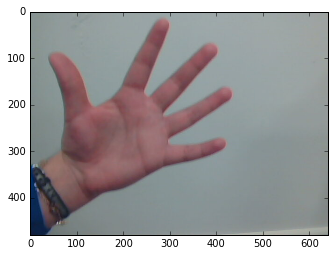

(480, 640, 3)


In [5]:
#img_bgr = cv2.imread('/Users/anthonypamart/Documents/SIR/EL_ROS/ROBOT_IMAGE_CONTROL/DATA/STOP/STOP-000')
img_bgr = cv2.imread(files[0])
img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()
#h,w =img_bgr.shape[:2]
#print(h,w)

print(img_rgb.shape)

### Find the correct range of colors and retrieve hand

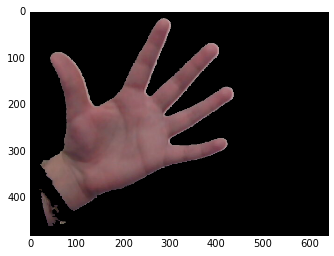

In [6]:

seuil=15
for i in range(len(img_rgb)):
    for j in range(len(img_rgb[i])):
        r = img_rgb[i][j][0]
        g = img_rgb[i][j][1]
        b = img_rgb[i][j][2]
        if (max(r,g,b)- min(r,g,b) < seuil) or (max(r,g,b)!=r):
            img_rgb[i][j]=[0,0,0]

plt.imshow(img_rgb)
plt.show()


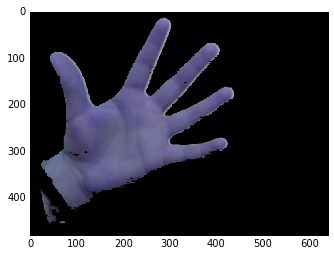

In [10]:
'''
Much much quicker 
There are many ways to perform pixel-wise threshold to separate "skin pixels" 
from "non-skin pixels", and there are papers based on virtually any colorspace (even with RGB). 

They worked with the YCbCr colorspace and got quite nice results, 
the paper also mentions a threshold that worked well for them
Face Segmentation Using Skin-Color Map in Videophone Applications by Chai and Ngan
using http://ieeexplore.ieee.org/document/767122/
'''

im_ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCR_CB)
skin_ycrcb_mint = np.array((0, 133, 77))
skin_ycrcb_maxt = np.array((255, 173, 127))
mask = cv2.inRange(im_ycrcb, skin_ycrcb_mint, skin_ycrcb_maxt)
skin_ycrcb = cv2.bitwise_and(img_bgr,img_bgr,mask = mask)

plt.imshow(skin_ycrcb)

plt.show()

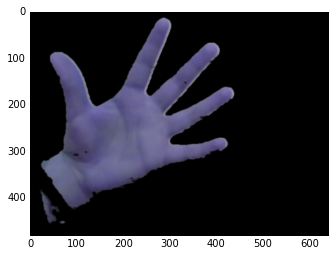

In [36]:
img_filtered = cv2.GaussianBlur(skin_ycrcb,(5,5),0) # Gaussian blur to 
blur = cv2.medianBlur(img_filtered, 5)

plt.imshow(blur)

plt.show()

### Filter and binarize the image 

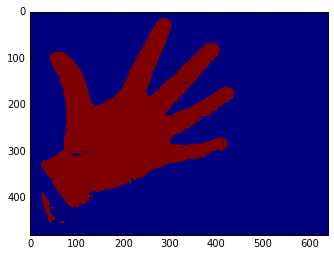

In [16]:
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
_,thresh2 = cv2.threshold(gray,20,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(thresh2)
plt.show()


### Find the correct contour of the image

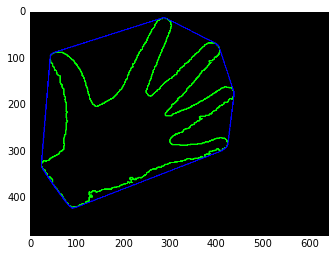

In [17]:
_, contours, hierarchy = cv2.findContours(thresh2, cv2.RETR_TREE ,cv2.CHAIN_APPROX_SIMPLE)
max_area = 0
max_perimeter = 0
ci = None
for i in range(len(contours)):
    cnt=contours[i]
    area = cv2.contourArea(cnt)
    if(area>max_area):
        max_area=area
        max_perimeter = cv2.arcLength(cnt,True)
        ci=i
hand_contour=contours[ci]
hull = cv2.convexHull(hand_contour)                                    
drawing = np.zeros(img_bgr.shape,np.uint8)
cv2.drawContours(drawing,[hand_contour],0,(0,255,0),2)
cv2.drawContours(drawing,[hull],0,(0,0,255),2)
plt.imshow(drawing)
plt.show()

In [18]:
len(hand_contour)

1106

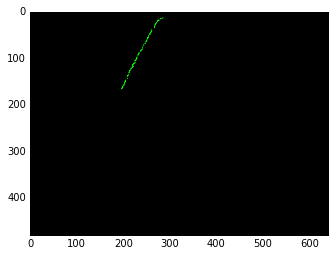

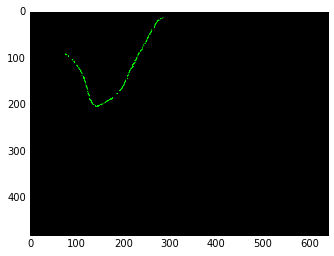

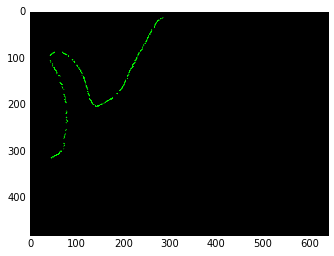

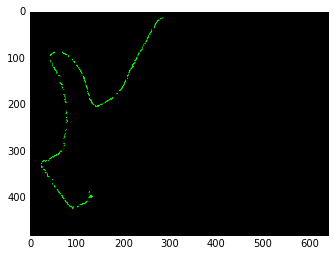

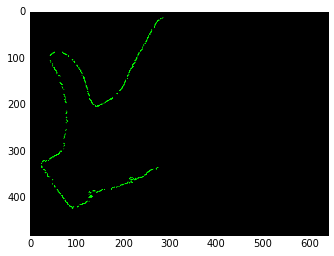

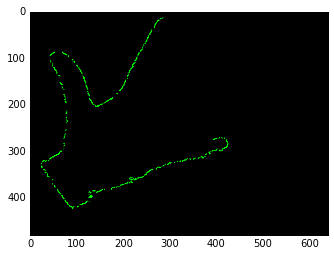

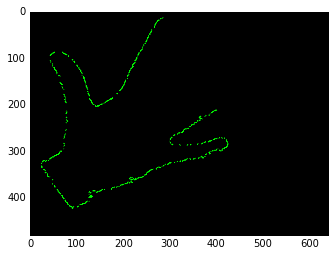

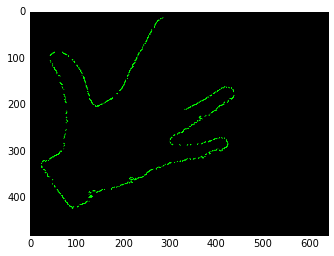

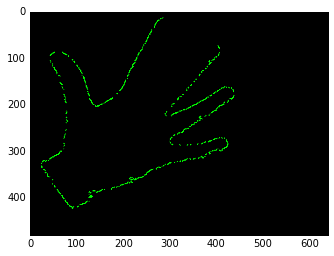

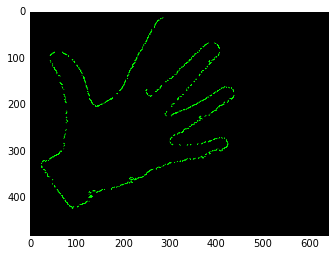

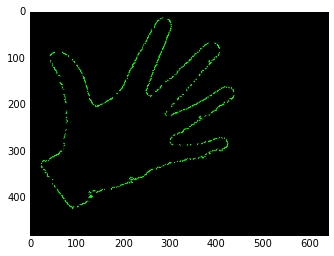

In [19]:
drawing = np.zeros(img_bgr.shape,np.uint8)
for i in range(len(hand_contour)-1):
    cv2.drawContours(drawing,[hand_contour[i],hand_contour[i+1]],0,(0,255,0),2)
    plt.imshow(drawing)
    if i%100 == 0 and i != 0:
        plt.show()

# Fourier descriptors

## Code to process fourier descriptors

In [20]:
k = 25

In [21]:
def get_fourier_descriptors(contour):
    '''Get fourier descriptors from contour 
        Keyword arguments: 
         - contour : the contour of the object
        return descriptors  , freqs
    '''
    #Passage en complexes
    contour_array = contour[:, 0, :]
    contour_complex = np.empty(contour_array.shape[:-1], dtype=complex)
    contour_complex.real = contour_array[:, 0]
    contour_complex.imag = contour_array[:, 1]

    # Soustraction de la moyenne 
    contour_complex_centre = np.empty(contour_array.shape[:-1], dtype=complex)
    mean_real = np.mean(contour_complex.real)
    mean_imag = np.mean(contour_complex.imag)
    print('mean real : {}'.format(mean_real))
    print('mean imag : {}'.format(mean_imag))
    
    contour_complex_centre.real = contour_complex.real - mean_real 
    contour_complex_centre.imag = contour_complex.imag - mean_imag 


    freqs = np.fft.fftfreq(contour_complex_centre.real.size)
    # calcul de la fft 
    descriptors = np.fft.fft(contour_complex_centre)
    # visualisation de la fft
    plt.plot(freqs, descriptors.real, freqs, descriptors.imag)
    plt.show()
    return descriptors, freqs
    
    # on tronque les descripteurs de fourier de 0 à kmax 
    # on construit entre -kmax et 0 

mean real : 252.29385171790236
mean imag : 208.92043399638337


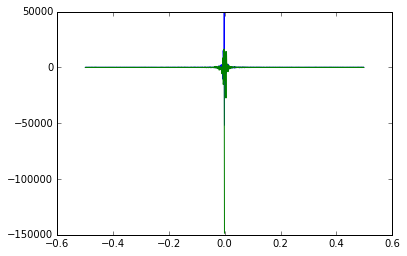

6.66208749134e-12
1106


In [23]:
fourier_descriptors,freqs = get_fourier_descriptors(hand_contour)
print(abs(fourier_descriptors[0])) # On a bien |a0| = 0
print(len(fourier_descriptors))

In [24]:
def truncate(descriptors, kmax):
    '''Function to truncate fourier descriptors between [-kmax, kmax]
    
        Keyword arguments: 
         - descriptors : the fourier descriptors given by fft
         - kmax : half the maximum number of descriptors you want 
    
        return selected_descriptors  , selected_freqs
    '''
    # Truncate between 0 and k 
    freqs_pos = [x for x in freqs if x>0]
    freqs_neg = [x for x in freqs if x<0]
    nb_tot_pos = len(freqs_pos)
    if kmax > len(freqs_neg):
        kmax = len(freqs_neg)

    #Contient pour le moment les descripteurs de fourier positifs 
    #on concatènera avec les descripteurs négatifs
    pos_descriptors = descriptors.copy()[:kmax+1]
    neg_descriptors = list(reversed(descriptors.copy()[nb_tot_pos:][:-kmax-1:-1]))
    print('nombre de descripteurs positifs (y compris 0) : {}'.format(len(pos_descriptors)))
    print('nombre de descripteurs neg : {}'.format(len(neg_descriptors)))

    selected_descriptors = np.concatenate((pos_descriptors,neg_descriptors))
    freq_pos = freqs.copy()[:kmax+1]
    freqs_neg = list(reversed(freqs.copy()[nb_tot_pos:][:-kmax-1:-1]))
    selected_freqs = np.concatenate((freq_pos, freqs_neg))

    # plot 
    plt.plot(selected_freqs, selected_descriptors.real, selected_freqs, selected_descriptors.imag)
    plt.show()
    return selected_descriptors, selected_freqs

nombre de descripteurs positifs (y compris 0) : 26
nombre de descripteurs neg : 25


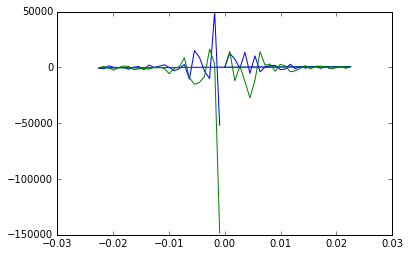

In [25]:
selected_descriptors, selected_freqs = truncate(fourier_descriptors, k)

In [26]:
def normalize(descriptors, kmax):
    '''Normalize the fourier descriptors according to 3 rules : 
        - Invariance to the direction of the contour path (I1) 
        - Invariance of scale (I2)
        - Invariance with rotation  (I3)
        
        Keyword arguments: 
         - descriptors : the truncated descriptors 
         - kmax : half the maximum number of descriptors you want 
        
        Return normalised coefficients 
    '''
    ### I1 : Invariance to the direction of the contour path
    nb_of_descriptors = len(descriptors)
    
    # On commence à 1 car on ne compte pas a0
    #len(descriptors)-1 correspond au dernier element de la liste 

    if(np.abs(descriptors[1])< np.abs(descriptors[-1])):
        for i in range(kmax):        
            # for real part 
            desc_temp_real = descriptors.real[i+1]
            descriptors.real[i+1] = descriptors.real[-1-i]
            descriptors.real[nb_of_descriptors-1-i] = desc_temp_real 
            
            #for imaginary part
            desc_temp_imag = descriptors.imag[i+1]
            descriptors.imag[i+1] = descriptors.imag[-1-i]
            descriptors.imag[nb_of_descriptors-1-i] = desc_temp_imag
    
    ### I2 : Invariance of scale
    d1 = np.abs(descriptors[1])
    descriptors.real = descriptors.real/d1
    descriptors.imag = descriptors.imag/d1
    
    ### I3 : Invariance with rotation 
    phi = np.angle(descriptors[-1]*descriptors[1])/2
    descriptors = descriptors*cmath.exp(-1j*phi)
    theta = np.angle(descriptors[-1])
    for i in range(math.ceil(len(descriptors)/2)):
        descriptors[i] = descriptors[i]*cmath.exp(-1j*theta*i)    
    for i in range(math.ceil(len(descriptors)/2),len(descriptors)):
        k = -(len(descriptors)-i)
        descriptors[i] = descriptors[i]*cmath.exp(-1j*theta*k)    
    return descriptors

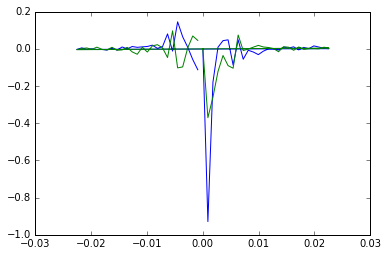

In [27]:
normalized_descriptors= normalize(selected_descriptors, k)
#plot 
plt.plot(selected_freqs, normalized_descriptors.real, selected_freqs, normalized_descriptors.imag)
plt.show()

In [34]:

def reconstruct(descriptors):
    """ reconstruct the image using the normalized descriptors and plot it
        Keyword arguments: 
         - descriptors : the normalized fourier descriptors
    """
    contour_reconstruct = np.fft.ifft(descriptors)
    contour_reconstruct = np.array(
        [contour_reconstruct.real, contour_reconstruct.imag])
    contour_reconstruct = np.transpose(contour_reconstruct)
    contour_reconstruct = np.expand_dims(contour_reconstruct, axis=1)
    # make positive
    if contour_reconstruct.min() < 0:
        contour_reconstruct -= contour_reconstruct.min()
    # normalization
    contour_reconstruct *= 800 / contour_reconstruct.max()
    # type cast to int32
    contour_reconstruct = contour_reconstruct.astype(np.int32, copy=False)
    black = np.zeros((800, 800), np.uint8)
    # draw and visualize
    cv2.drawContours(black, [contour_reconstruct], -1, 255, thickness=-3)
    cv2.imshow("black", black)
    cv2.waitKey(10000)
    cv2.imwrite("reconstruct_result.jpg", black)
    cv2.destroyAllWindows()
    plt.imshow(black, cmap='gist_gray_r')
    plt.show()

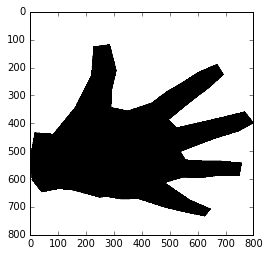

-1

In [35]:
reconstruct(normalized_descriptors)
cv2.waitKey(1000)